**Bài đánh giá cuối kỳ.**

Mục tiêu của bài đánh giá là xây dựng bộ phân lớp cho bài toán phân tích cảm xúc (sentiment analysis). Các yêu cầu chính bao gồm:

1. Đọc dữ liệu từ tệp SA-Dataset.csv
2. Tiền xử lý dữ liệu
3. Chuyển dữ liệu về dạng vectors
4. Tính độ tương tự
5. Trích chọn đặc trưng
6. Huấn luyện và đánh giá mô hình

**Cài đặt các thư viện**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Ben/NLP/FinalExam/

/content/drive/MyDrive/Ben/NLP/FinalExam


In [4]:
%%capture
! pip install nltk
! pip install torch
! pip install nose
! pip install transformers
! pip install python-Levenshtein
! pip install torchtext
!pip install underthesea
!pip install datasets

In [6]:
from transformers import BertModel, BertTokenizer
from transformers import AutoModel, AutoTokenizer
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import gensim
import nltk
import torchtext
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

**Đọc dữ liệu từ tệp SA-Dataset.csv**

Tệp dữ liệu cần lưu cùng thư mục của file mã nguồn

In [7]:
file_path = '/content/drive/MyDrive/Ben/NLP/FinalExam/SA_Dataset.csv'
df = pd.read_csv(file_path)

**Đọc 5000 mẫu từ tập dữ liệu**

In [8]:
data = df.drop(['index','date_time','label'],axis=1)
data.head(5000)

,comment,n_star
0,"Máy ok, k chê điểm nào, chính thức là fans ViV...",5
1,"Mới sài được 3 ngày sản phẩm thì khá là ok , l...",5
2,Dùng tốt chơi game bao mượt không nóng như lời...,5
3,"Có ai giống mh kg, mh mua ip 7 plus , mấy bị h...",3
4,Ko bjk ngày mai có ra đổi đc ko đây. Mới mua h...,2
...,...,...
4995,Mới mua em nó về chơi lq có thấy nóng ji đâu. ...,5
4996,. Mới mua trải nghiệm cũng thấy ok có cái vide...,3
4997,Sản phẩm Iphone 7 plus quá tuyệt vời. Thiết kế...,5
4998,"Wow , máy dùng rấy ngon lành , cấu hình thì lớ...",5


## **Yêu cầu 1: Tiền xử lý dữ liệu**

### **Câu 1: Làm sạch dữ liệu: viết một hàm loại bỏ các ký tự đặc biệt, emoji của chuỗi đầu vào bên dưới.**

In [9]:
def clean_text(text):
    #vietnamese 
    temp = r'[^a-z0-9A-Z_ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚĂĐĨŨƠàáâãèéêìíòóôõùúăđĩũơƯĂẠẢẤẦẨẪẬẮẰẲẴẶẸẺẼỀỀỂưăạảấầẩẫậắằẳẵặẹẻẽềềểỄỆỈỊỌỎỐỒỔỖỘỚỜỞỠỢỤỦỨỪễếệỉịọỏốồổỗộớờởỡợụủứừỬỮỰỲỴÝỶỸửữựỳỵỷỹ]/u'
    text= re.sub(temp, ' ', text, re.I|re.A)
    # text = text.lower()
    # text = text.strip()
    return text.strip().lower()

In [10]:
data['nameLabel'] = data['n_star'].apply(lambda x: "Positive" if x > 3 else "Negative")
data['label'] = data['n_star'].apply(lambda x: 1 if x > 3 else 0)
data.head(100)

,comment,n_star,nameLabel,label
0,"Máy ok, k chê điểm nào, chính thức là fans ViV...",5,Positive,1
1,"Mới sài được 3 ngày sản phẩm thì khá là ok , l...",5,Positive,1
2,Dùng tốt chơi game bao mượt không nóng như lời...,5,Positive,1
3,"Có ai giống mh kg, mh mua ip 7 plus , mấy bị h...",3,Negative,0
4,Ko bjk ngày mai có ra đổi đc ko đây. Mới mua h...,2,Negative,0
...,...,...,...,...
95,Sản phẩm quá tốt cho dân cày game đồ họa cấu h...,5,Positive,1
96,Mua 2 máy. Chất lượng tốt tuy nhiên NV giao hà...,5,Positive,1
97,"con thứ 2 mua cho vợ, chụp cam sau thì tuyệt v...",5,Positive,1
98,"Mình mới mua máy được 1 tháng, tất cả đều ok c...",5,Positive,1


In [11]:
#Chuyển các đánh giá tờ bậc 5 sao sang 2 nhãn Positive và Negative
def clean_label(text):
    star = int(text)
    if star >=4:
      return 'Positive'
    else:
      return 'Negative'
    
    
### BEGIN SOLUTION

### END SOLUTION

In [12]:
text = data['comment'].map(lambda x: clean_text(str(x)))
label = data['n_star'].map(lambda x: clean_label(str(x)))

In [13]:
text

0        máy ok, k chê điểm nào, chính thức là fans viv...
1        mới sài được 3 ngày sản phẩm thì khá là ok , l...
2        dùng tốt chơi game bao mượt không nóng như lời...
3        có ai giống mh kg, mh mua ip 7 plus , mấy bị h...
4        ko bjk ngày mai có ra đổi đc ko đây. mới mua h...
                               ...                        
11117    8g. cái đi đánh là mạng giật giật ko chịu nổi....
11118    mua dk giảm 500k mà lỗi lòi ra hết treo màn hì...
11119    máy sài 3 tháng rồi rất ok.pin trâu khỏi nói s...
11120    rất tiếc hàng realme ko có ốp lưng ngoài , nên...
11121    mình rất thất vọng khi mua máy này. bắt wifi c...
Name: comment, Length: 11122, dtype: object

In [14]:
label

0        Positive
1        Positive
2        Positive
3        Negative
4        Negative
           ...   
11117    Negative
11118    Negative
11119    Positive
11120    Negative
11121    Negative
Name: n_star, Length: 11122, dtype: object

In [15]:
### BEGIN HIDDEN TESTS
from nose.tools import assert_equal
test_text = """5 sao máy đẹp camera đc
Game ngon có thể nói là máy phân khúc giá 2990 máy này là trùm quá ngon
Khi mua về t thấy âm thanh trong game My Tom nghe cứ ừừ 
Mặc dù vậy máy ngon 😊"""

t = clean_text(test_text)
t
### END HIDDEN TESTS

'5 sao máy đẹp camera đc\ngame ngon có thể nói là máy phân khúc giá 2990 máy này là trùm quá ngon\nkhi mua về t thấy âm thanh trong game my tom nghe cứ ừừ \nmặc dù vậy máy ngon 😊'

### Chia dữ liệu thành tập: train/val/test, với tỷ lệ: 70/15/15 (không tính điểm)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(list(text), list(label), random_state=42, shuffle=True, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, random_state=42, shuffle=True)
len(X_train), len(X_val), len(X_test)

(6355, 1396, 1669)

In [17]:
X_train[0]

'đt pin trâu ,máy khá to và dài không phù hợp vs người tay nhỏ.cảm ứng không nhạy có khi phải ấn 2 lần, chơi lq thì nút chiêu  ở xa góc vs lại hơi nhỏ nên không quen bấm toàn hụt'

In [18]:
y_train[0]

'Negative'

In [19]:
!gdown 1z5XkFhPHGGAjW-0CaQQvwB1D0DxiIHkb

Downloading...
From: https://drive.google.com/uc?id=1z5XkFhPHGGAjW-0CaQQvwB1D0DxiIHkb
To: /content/drive/MyDrive/Ben/NLP/FinalExam/baomoi.vn.model.bin
100% 533M/533M [00:01<00:00, 273MB/s]


## **Phần 2: Biểu diễn**

###Câu 2: chuyển một từ thành một vector sử dụng word2vec với mô hình có sẵn

In [39]:
### YOUR CODE HERE
# download word2vec
path_file_bin = '/content/drive/MyDrive/Ben/NLP/FinalExam/baomoi.vn.model.bin'
# def get_embedding_from_ggnews(word, wv = wv):
#     try:
#         word_vec = wv[word]
#         return torch.tensor(word_vec).reshape(1,-1)
#     except:
#         return torch.rand((1, 300)).reshape(1,-1)


model = gensim.models.KeyedVectors.load_word2vec_format(path_file_bin, binary=True)
def get_embedding_from_ggnews(word):
    return model[word].reshape(1,-1)
### END YOUR CODE HERE

### BEGIN SOLUTION

### END SOLUTION

In [40]:
### BEGIN HIDDEN TESTS
test_word = 'xin'
t = get_embedding_from_ggnews(test_word)
print(t)
assert_equal(t.shape, (1, 300))
### END HIDDEN TESTS

[[-7.30723798e-01  4.01523501e-01 -2.01250982e+00 -6.46103844e-02
  -5.39499104e-01  2.71564163e-02  1.99037954e-01 -8.76430392e-01
  -1.41843200e+00  1.36141229e+00  1.92257226e+00 -3.21104199e-01
  -1.30109727e-01 -4.07765239e-01 -2.41471142e-01  6.17075145e-01
  -4.79032069e-01  2.75668561e-01 -2.09098125e+00  1.39199352e+00
  -1.89044631e+00  8.96091640e-01 -1.73074707e-01  1.13413715e+00
  -2.63840944e-01 -5.80875650e-02  1.68166840e+00  2.62611103e+00
  -1.47897410e+00  4.16716725e-01 -1.53255355e+00  1.12240303e+00
   3.66355598e-01 -2.29657483e+00 -1.08169031e+00 -1.98279276e-01
   1.20802951e+00 -8.92981350e-01  2.51221985e-01 -5.54749012e-01
   4.94613826e-01  6.10779345e-01  1.63601840e+00  1.52097452e+00
  -1.08981287e+00 -7.80467510e-01 -5.06640434e-01  1.87516257e-01
   2.10150456e+00  9.95497167e-01 -5.14945745e-01  1.34911776e+00
   7.65572071e-01 -5.31980097e-01 -5.68834901e-01 -8.28510582e-01
   9.29541469e-01 -1.50127232e+00 -2.66130829e+00 -7.26325631e-01
   1.09956

### **Câu 4: chuyển một chuỗi thành một vector sử dụng trung bình cộng của các vector từ bằng cách dùng word2vec.**


In [41]:
from underthesea import word_tokenize
### YOUR CODE HERE
### using ggnews to extract word embeddings
def seq2vec(text):
    # tokenize text
    tokens = word_tokenize(text)
    # get embedding
    embeddings = [get_embedding_from_ggnews(token) for token in tokens]
    # get mean of embeddings
    return np.mean(embeddings, axis=0)
    
### END YOUR CODE HERE

### BEGIN SOLUTION

### END SOLUTION

### Câu 5: chuyển một chuỗi ở Câu 4 thành vector sử dụng BERT.

In [42]:
### YOUR CODE HERE
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
bert_model = AutoModel.from_pretrained('bert-base-multilingual-uncased')

def extract_feature_from_bert(tokenizer, bert, text):
    input_ids = torch.tensor(tokenizer.encode(text, add_special_tokens=True)).unsqueeze(0)
    with torch.no_grad():
        last_hidden_states = bert(input_ids)[0]
    return last_hidden_states[0,0,:].numpy()
    
### END YOUR CODE HERE

### BEGIN SOLUTION

### END SOLUTION

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
### BEGIN HIDDEN TESTS
test_text = 'Tôi lên là Văn Mai Hương, rất vui khi đơực làm quen vứi bạn'
def test4(tokenizer, bert, text):
    input = tokenizer(text, return_tensors='pt')

    with torch.no_grad():
        bert_output =  bert(input['input_ids'], input['attention_mask'])
    return bert_output.last_hidden_state[:, 0]

t = test4(bert_tokenizer, bert_model, test_text)
assert_equal(t.size(), extract_feature_from_bert(bert_tokenizer, bert_model, test_text).size())
### END HIDDEN TESTS

### **Câu 6: Tính độ tương tự giữa 2 tweets 101 và 1001 sử dụng word2vec**

In [44]:
### YOUR CODE HERE
def caculate_similarity_word2vec(text1, text2): 
    # get embedding
    embedding1 = seq2vec(text1)
    embedding2 = seq2vec(text2)
    # caculate cosine similarity
    similarity = cosine_similarity([embedding1], [embedding2])
    return similarity[0][0]
    
### YOUR CODE HERE

### BEGIN SOLUTION

### END SOLUTION

### **Câu 7: Tính độ tương tự giữa 2 tweets 101 và 1001 sử dụng BERT**

In [56]:
### YOUR CODE HERE
from sklearn.metrics.pairwise import cosine_similarity
def caculate_similarity_bert(text1, text2):
    # get embedding
    embedding1 = extract_feature_from_bert(bert_tokenizer, bert_model, text1)
    embedding2 = extract_feature_from_bert(bert_tokenizer, bert_model, text2)
    # caculate cosine similarity
    similarity = cosine_similarity([embedding1], [embedding2])
    return similarity[0][0]
### YOUR CODE HERE

### BEGIN SOLUTION

### END SOLUTION

In [57]:
### BEGIN HIDDEN TESTS
t = caculate_similarity_bert(X_train[1], X_train[0])
print(X_train[1])
print(X_train[0])
print(t)
# check if t is between [0, 1]
t = 1 if t>=0.0 and t<=1.0 else 0

assert_equal(t, 1)
### END HIDDEN TESTS

thiết kế đẹp, màn hình liền mạch, cam sau đẹp chất ảnh trong hơn oppo rất nhiều , hiệu năng nhanh mượt ở các tác vụ cơ bản như face, zalo, you tube, màn hiển thị rực rỡ
đt pin trâu ,máy khá to và dài không phù hợp vs người tay nhỏ.cảm ứng không nhạy có khi phải ấn 2 lần, chơi lq thì nút chiêu  ở xa góc vs lại hơi nhỏ nên không quen bấm toàn hụt
0.9939457


### Câu 7: Trực quan hoá phân phối của dữ liệu:

In [58]:
def plot_len_distribution(texts):
    plt.figure(figsize=(12, 6))
    plt.hist([len(text.split()) for text in texts], bins=100)
    plt.title('Token per text')
    plt.xlabel('Number of token')
    plt.ylabel('# samples')
    plt.show()

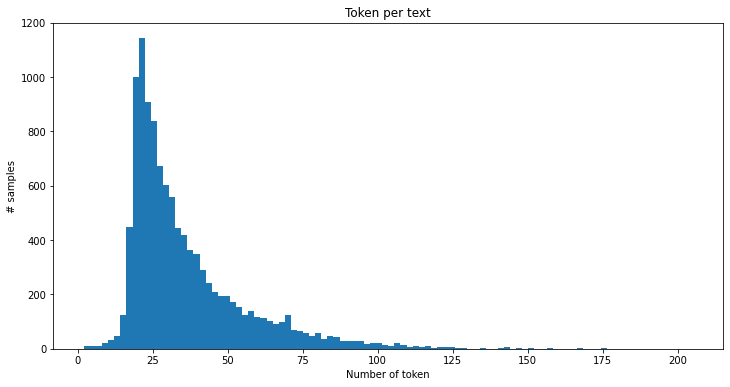

In [59]:
plot_len_distribution(text)

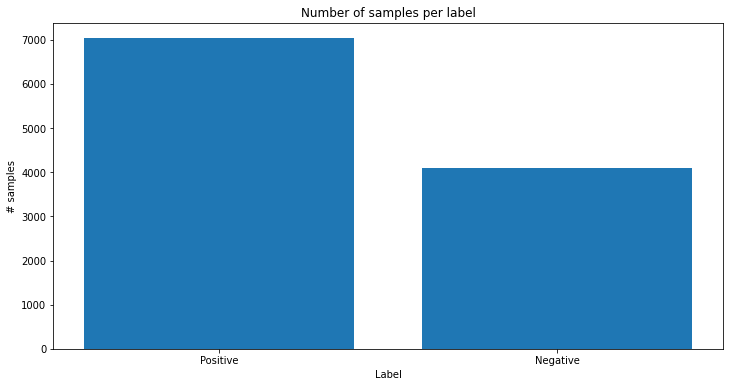

In [60]:
#Vẽ biểu đồ thể hiện số lượng sample tương ứng với mỗi label
labels = list(label)
### YOUR CODE HERE
def sample_per_label(labels):
    # get unique labels
    unique_labels = list(set(labels))
    # get number of samples per label
    num_samples = [labels.count(label) for label in unique_labels]
    # plot
    plt.figure(figsize=(12, 6))
    plt.bar(unique_labels, num_samples)
    plt.title('Number of samples per label')
    plt.xlabel('Label')
    plt.ylabel('# samples')
    plt.show()
### YOUR CODE HERE

### BEGIN SOLUTION

### BEGIN SOLUTION

sample_per_label(labels)

### Sử dụng thư viện Flair để xây dựng các mô hình phân lớp. ###

In [61]:
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
#Lưu dataset đã xử lý dưới dạng CSV
df_train = pd.DataFrame(list(zip(X_train, y_train)),
               columns =['text', 'label'])
df_val = pd.DataFrame(list(zip(X_val, y_val)),
               columns =['text', 'label'])
df_test = pd.DataFrame(list(zip(X_test, y_test)),
               columns =['text', 'label'])

df_train.to_csv(index=False,sep='\t',path_or_buf='/content/drive/MyDrive/Ben/NLP/FinalExam/data/train.csv')
df_val.to_csv(index=False,sep='\t',path_or_buf='/content/drive/MyDrive/Ben/NLP/FinalExam/data/val.csv')
df_test.to_csv(index=False,sep='\t',path_or_buf='/content/drive/MyDrive/Ben/NLP/FinalExam/data/test.csv')

In [ ]:
from flair.data import Corpus
from flair.datasets import CSVClassificationCorpus


# this is the folder in which train, test and dev files reside
data_folder = '/content/drive/MyDrive/Ben/NLP/FinalExam/data'

#Load dữ liệu từ các file CSV mới tạo
data = pd.read_csv(data_folder)

### YOUR CODE HERE

### YOUR CODE HERE


In [ ]:
corpus.train[2]

In [ ]:
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings, TransformerWordEmbeddings, DocumentPoolEmbeddings, DocumentCNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from pathlib import Path

### **Câu 8: Tạo một mô hình LSTM nhận đầu vào là embedding(last_hidden_state) của mỗi token từ BERT. Tham số:**
- rnn layer: input_size=hidden_size of bert, num_layers=2, bidirectional=True, hidden_size buffet
- Một lớp fully-connected cho phân lớp.

In [ ]:
### YOUR CODE HERE

def __init__(self, hidden_size, num_layers=2, p=0.3, bidirectional=True, batch_first=True):
        super(LSTM, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(p)
        self.rnn = nn.LSTM(input_size=self.bert.config.hidden_size, hidden_size=hidden_size, num_layers=num_layers,
                        dropout=p, bidirectional=bidirectional, batch_first=batch_first)
        D = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * D, 1)
    def forward(self, input_ids, att_mask):
        with torch.no_grad():
            last_hidden_state = self.bert(input_ids, att_mask).last_hidden_state
        last_hidden_state = self.dropout(last_hidden_state)

        rnn_output, _ = self.rnn(last_hidden_state)
        output = self.fc(rnn_output[:, -1])
        return torch.sigmoid(output)
### YOUR CODE HERE

### **Câu 9: Sử dụng BERT để trích rút đặc trưng và dụng 1 lớp fully-connected cho phân loại**

In [ ]:
### YOUR CODE HERE
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(self.bert.config.hidden_size, 1)
    def forward(self, input_ids, att_mask):
        with torch.no_grad():
            last_hidden_state = self.bert(input_ids, att_mask).last_hidden_state
        
        output = self.fc(last_hidden_state[:, 0])
        return torch.sigmoid(output)

### YOUR CODE HERE


#Tiến hành FINE_TUNE mô hình BERT#
Hướng dẫn tiến hành Fine-tune mô hình BERT

In [ ]:
!pip install datasets
#Tiến hành Download bộ dữ liệu
from datasets import load_dataset

dataset = load_dataset("yelp_review_full")
dataset["train"][100]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)


Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset yelp_review_full downloaded and prepared to /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

In [ ]:
from transformers import AutoTokenizer
#Load mô hình cần Fine-tune 
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

#Tiến hành Tokenize chuẩn bị dữ liệu cho mô hình
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

  0%|          | 0/650 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [ ]:
#Chuẩn bị dữ liệu
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [ ]:
from transformers import AutoModelForSequenceClassification

#Tạo mô hình Fine-tune
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)



Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
from transformers import TrainingArguments

#Tiến hành caiì đặt tham số
training_args = TrainingArguments(output_dir="test_trainer")

In [ ]:
#Khởi tạo thang đo
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  """


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
trainer.save_model()

Saving model checkpoint to test_trainer
Configuration saved in test_trainer/config.json
Model weights saved in test_trainer/pytorch_model.bin
